# IPL Score Predictor - Model Evaluation

This notebook loads and evaluates the trained neural network model for IPL score prediction.
It uses the saved model, scaler, and encoders to make predictions on test data.

In [1]:
# Basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('IPLScorePredictor_Eval')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

2025-05-07 11:42:49,806 - INFO - Using device: cuda


## Load Model Architecture

In [2]:
class IPLScorePredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3, output_size=2, temperature=1.0):
        super(IPLScorePredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.temperature = temperature
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
    
    def forward(self, x, seq_lengths=None):
        batch_size = x.size(0)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last output
        out = out[:, -1, :]
        
        # Forward through fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

## Load Model and Components

In [3]:
def load_model_components():
    """Load the trained model and its components"""
    try:
        # Load the model checkpoint
        checkpoint = torch.load('best_ipl_model.pth', map_location=device,weights_only=False)
        
        # Initialize model with saved parameters
        model = IPLScorePredictor(**checkpoint['model_params'])
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        
        # Load scaler and encoder
        with open('train/scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        with open('train/team_encoder.pkl', 'rb') as f:
            team_encoder = pickle.load(f)
        with open('train/numerical_features.pkl', 'rb') as f:
            numerical_features = pickle.load(f)
            
        logger.info("Successfully loaded model and components")
        return model, scaler, team_encoder, numerical_features, checkpoint
    
    except Exception as e:
        logger.error(f"Error loading model components: {e}")
        return None, None, None, None, None

# Load the components
model, scaler, team_encoder, numerical_features, checkpoint = load_model_components()

2025-05-07 11:42:49,980 - INFO - Successfully loaded model and components


## Data Processing and Evaluation

In [4]:
class IPLDataset(Dataset):
    def __init__(self, df, numerical_data, target_cols=None):
        self.df = df
        self.numerical_data = numerical_data
        self.target_cols = target_cols or ['total_runs', 'is_wicket']
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get features
        numerical_features = torch.tensor(self.numerical_data[idx], dtype=torch.float32)
        batting_team = torch.tensor([self.df.iloc[idx]['batting_team']], dtype=torch.float32)
        bowling_team = torch.tensor([self.df.iloc[idx]['bowling_team']], dtype=torch.float32)
        
        # Combine features
        features = torch.cat([numerical_features, batting_team, bowling_team])
        
        # Get targets
        targets = torch.tensor([self.df.iloc[idx][col] for col in self.target_cols], dtype=torch.float32)
        
        return features, targets

def prepare_test_data(test_csv_path='test/test_data.csv'):
    """Prepare test data for evaluation"""
    try:
        # Load test data
        df = pd.read_csv(test_csv_path)
        
        # Scale numerical features
        numerical_data = scaler.transform(df[numerical_features])
        
        # Create dataset
        test_dataset = IPLDataset(df, numerical_data)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        logger.info(f"Prepared test data with {len(df)} samples")
        return test_loader, df
    
    except Exception as e:
        logger.error(f"Error preparing test data: {e}")
        return None, None

def evaluate_model(model, test_loader):
    """Evaluate model performance"""
    model.eval()
    runs_pred = []
    runs_true = []
    wickets_pred = []
    wickets_true = []
    
    with torch.no_grad():
        for features, targets in test_loader:
            features = features.to(device)
            outputs = model(features.unsqueeze(1))
            
            # Process predictions
            run_pred = outputs[:, 0].cpu().numpy()
            wicket_pred = (torch.sigmoid(outputs[:, 1]) > 0.5).float().cpu().numpy()
            
            runs_pred.extend(run_pred)
            wickets_pred.extend(wicket_pred)
            runs_true.extend(targets[:, 0].numpy())
            wickets_true.extend(targets[:, 1].numpy())
    
    # Calculate metrics
    runs_mae = np.mean(np.abs(np.array(runs_pred) - np.array(runs_true)))
    wickets_accuracy = np.mean(np.array(wickets_pred) == np.array(wickets_true))
    
    return {
        'runs_pred': runs_pred,
        'runs_true': runs_true,
        'wickets_pred': wickets_pred,
        'wickets_true': wickets_true,
        'runs_mae': runs_mae,
        'wickets_accuracy': wickets_accuracy
    }

# Prepare and evaluate
test_loader, test_df = prepare_test_data()
if test_loader is not None:
    results = evaluate_model(model, test_loader)
    
    print(f"\nEvaluation Results:")
    print(f"Runs MAE: {results['runs_mae']:.2f}")
    print(f"Wickets Accuracy: {results['wickets_accuracy']:.2%}")

2025-05-07 11:42:50,028 - INFO - Prepared test data with 8417 samples



Evaluation Results:
Runs MAE: 1.33
Wickets Accuracy: 56.69%


## Visualization

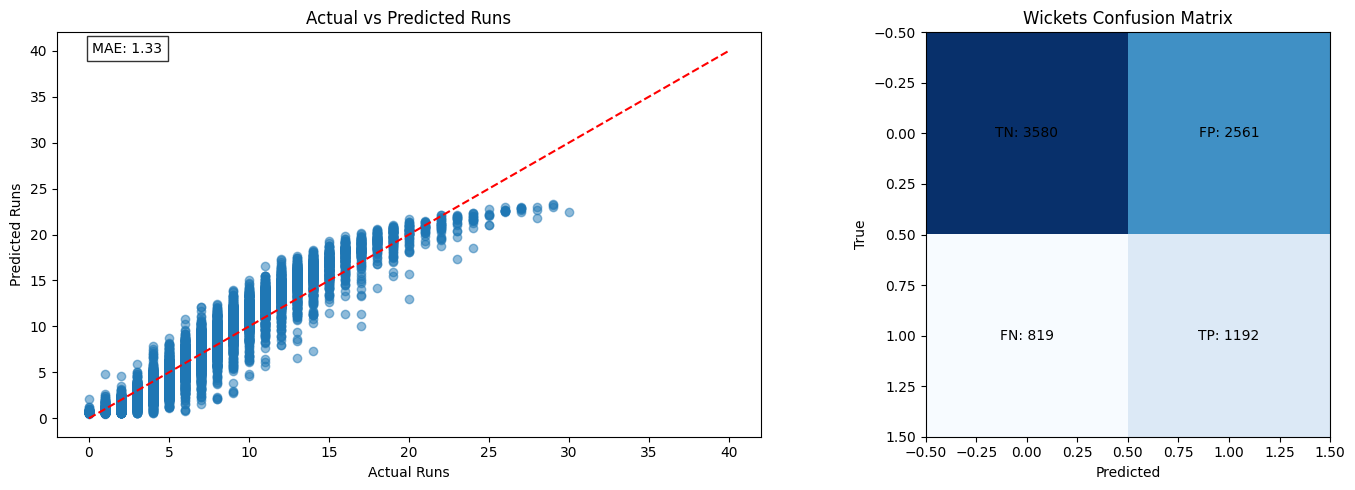

In [5]:
def plot_results(results):
    """Plot evaluation results"""
    plt.figure(figsize=(15, 5))
    
    # Plot runs comparison
    plt.subplot(1, 2, 1)
    plt.scatter(results['runs_true'], results['runs_pred'], alpha=0.5)
    plt.plot([0, 40], [0, 40], 'r--')
    plt.title('Actual vs Predicted Runs')
    plt.xlabel('Actual Runs')
    plt.ylabel('Predicted Runs')
    plt.text(0.05, 0.95, f"MAE: {results['runs_mae']:.2f}",
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Plot wickets confusion matrix
    plt.subplot(1, 2, 2)
    wickets_true = np.array(results['wickets_true'])
    wickets_pred = np.array(results['wickets_pred'])
    
    tn = np.sum((wickets_true == 0) & (wickets_pred == 0))
    fp = np.sum((wickets_true == 0) & (wickets_pred == 1))
    fn = np.sum((wickets_true == 1) & (wickets_pred == 0))
    tp = np.sum((wickets_true == 1) & (wickets_pred == 1))
    
    plt.imshow([[tn, fp], [fn, tp]], cmap='Blues')
    plt.title('Wickets Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    
    # Add text annotations
    plt.text(0, 0, f'TN: {tn}', ha='center', va='center')
    plt.text(1, 0, f'FP: {fp}', ha='center', va='center')
    plt.text(0, 1, f'FN: {fn}', ha='center', va='center')
    plt.text(1, 1, f'TP: {tp}', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

if 'results' in locals():
    plot_results(results)